In [1]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [2]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Trinity/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

In [3]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/geojson/trinity.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/geojson/trinity-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [4]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


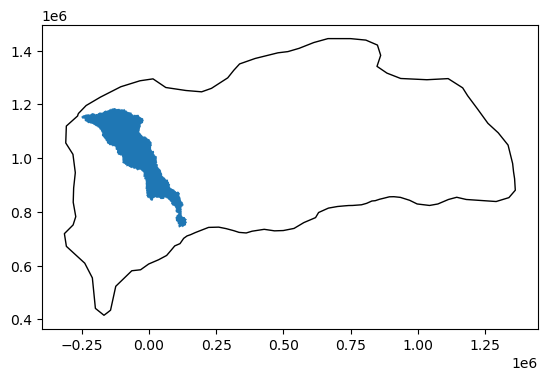

In [5]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [6]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx       -2.528011e+05
miny        7.420917e+05
maxx        1.406649e+05
maxy        1.186560e+06
x          -4.742350e+04
y           1.019272e+06
range_x     3.934660e+05
range_y     4.444687e+05
area_km2    6.506943e+04
Name: 0, dtype: float64 minx       -3.150469e+05
miny        4.155483e+05
maxx        1.362324e+06
maxy        1.444762e+06
x           4.456539e+05
y           1.016893e+06
range_x     1.677371e+06
range_y     1.029214e+06
area_km2    1.285695e+06
Name: 0, dtype: float64


In [7]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [ ]:
# Set simulation parameters
lam = 10                   # average number of storms per year
n_full = 10000            # number of years to simulate
n_part = 1000

# Run the simulations
df_full_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_full, method = 'uniform')
df_full_monte = get_return_period(df_full_monte)

df_part_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'uniform')
df_part_monte = get_return_period(df_part_monte)

df_part_is = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'truncnorm',dist_x = dist_x, dist_y = dist_y)
df_part_is = get_return_period(df_part_is)

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


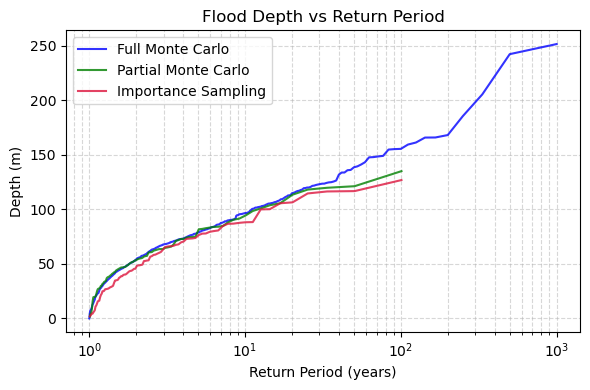

In [9]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_full_monte['return_period'], df_full_monte['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_part_monte['return_period'], df_part_monte['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_part_is['return_period'], df_part_is['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (m)')
plt.title('Flood Depth vs Return Period')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

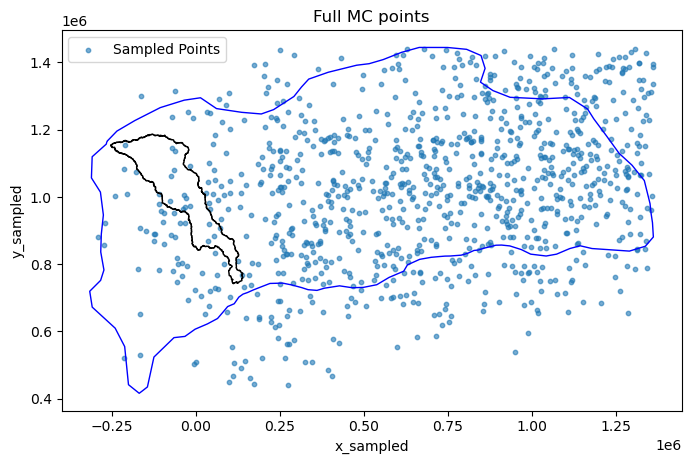

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
df_full_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Full MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

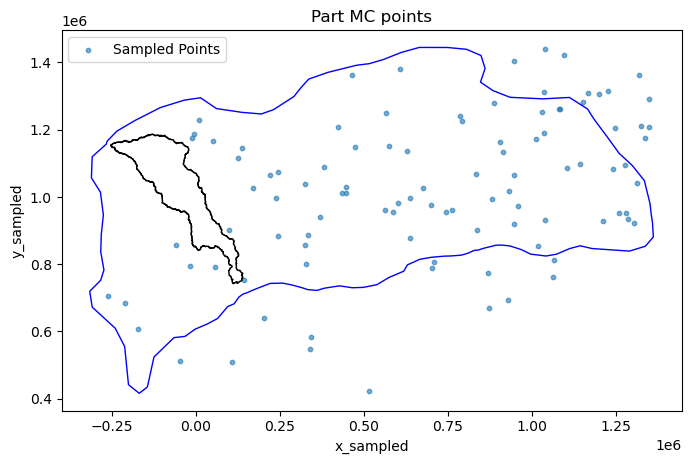

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Part MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

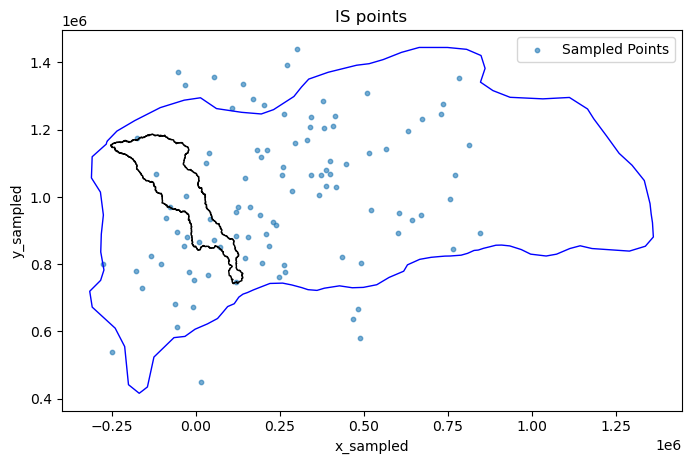

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_is.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

In [16]:
df_part_is

,name,path,x,y,x_sampled,y_sampled,weight,prob,x_del,y_del,depth,intersected,prob_exceed,return_period
0,20020221_T011,/workspaces/Importance-Sampling-for-SST/data/0...,-1.950045e+06,2.967456e+06,-1.888705e+06,3.103959e+06,1.023170,0.316588,61340.152794,136503.297245,290.330322,1,0.009901,101.000000
1,20071202_T003,/workspaces/Importance-Sampling-for-SST/data/0...,-1.976766e+06,2.922578e+06,-2.063187e+06,2.872937e+06,1.091282,0.344333,-86420.789885,-49641.403591,234.747452,1,0.019802,50.500000
2,20090106_T004,/workspaces/Importance-Sampling-for-SST/data/0...,-1.959672e+06,2.948753e+06,-1.850515e+06,3.084627e+06,1.051575,0.215888,109157.260230,135873.526348,218.550003,1,0.029703,33.666667
3,19960206_T006,/workspaces/Importance-Sampling-for-SST/data/0...,-2.003793e+06,2.859621e+06,-1.963648e+06,2.932510e+06,0.109712,0.013745,40144.498282,72888.520769,206.020767,1,0.039604,25.250000
4,20200205_T035,/workspaces/Importance-Sampling-for-SST/data/0...,-1.958539e+06,2.933316e+06,-1.973164e+06,2.897379e+06,0.171428,0.025409,-14624.953251,-35937.303162,194.160782,1,0.049505,20.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20030121_T330,/workspaces/Importance-Sampling-for-SST/data/0...,-1.970793e+06,2.911810e+06,-1.889982e+06,2.916266e+06,0.161283,0.024692,80810.949193,4455.822373,64.048042,1,0.950495,1.052083
96,20151217_T177,/workspaces/Importance-Sampling-for-SST/data/0...,-2.035839e+06,2.795456e+06,-1.972155e+06,2.959094e+06,0.102032,0.020514,63683.508441,163638.452787,59.519226,1,0.960396,1.041237
97,20201010_T082,/workspaces/Importance-Sampling-for-SST/data/0...,-1.981659e+06,2.899878e+06,-1.984824e+06,3.090409e+06,0.618526,0.112147,-3164.827377,190530.573977,53.612991,1,0.970297,1.030612
98,19910111_T112,/workspaces/Importance-Sampling-for-SST/data/0...,-1.984691e+06,2.884436e+06,-1.987288e+06,2.945646e+06,0.119422,0.014122,-2596.334447,61209.937778,51.463295,1,0.980198,1.020202
